## Reference paper

Wavelet Neural Network(WNN)
- https://www.researchgate.net/publication/237036240_EOG_Artifact_Removal_using_a_Wavelet_Neural_Network

## Reference for the data
- https://data.mendeley.com/datasets/wb6yvr725d/4

    - EEG electrodes (Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, T6, Fz, Cz, Pz) were placed according to the 10–20 International System,
    - Sampling frequency = 200 Hz
    - Bandpass filter at 0.5-40Hz
    - Notch filter at 50 Hz
    - Each dataset has 30 seconds duration
    - OAs occur due to eye moment and eye-blinks and have freuqncy ranges of 0-7 Hz and 8-13 Hz

## Select 1st dataset (54 subjects * each has 19 EEG channels + 2 EOG channels)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.io
import scipy.signal
import seaborn as sns; sns.set_style("darkgrid") # styling
import pywt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback
from keras.callbacks import CSVLogger

def createSubplot(n):
    fig,axs = plt.subplots(n,figsize=(15,8))
    fig.tight_layout(pad=3.0)
    return fig,axs

number_subjects = 54
initial_fs = 200
EEG_electrodes = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 
                  'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']

initial_pure_dataset = scipy.io.loadmat("semi_EEG-EOG/Pure_Data.mat")
initial_cont_dataset = scipy.io.loadmat("semi_EEG-EOG/Contaminated_Data.mat")
initial_HEOG = scipy.io.loadmat("semi_EEG-EOG/HEOG.mat")
initial_VEOG =scipy.io.loadmat("semi_EEG-EOG/VEOG.mat")

In [ ]:
def createSubplot(n):
    fig,axs = plt.subplots(n,figsize=(15,8))
    fig.tight_layout(pad=3.0)
    return fig,axs

### Calculte FFT
def next_pow2(x):
    return 1<<(x-1).bit_length()

def calculate_FFT(inputSignal, fs, n_zeropad=0, window="False", timescaling=1):
    
    my_signal = inputSignal.copy()
    
    if window != "False":
        window = get_window(window, inputSignal.shape[0])
        my_signal *= window # multiply signal by window to reduce fluctuation in frequency-domain
        
    time_zeropadding =  np.hstack((my_signal, np.zeros(int(n_zeropad)))) # zero-padding in time-domain
    nfft = time_zeropadding.shape[0]           # get the number of samples in the signal
#     nfft = next_pow2(nfft)                                     # FFT is more efficient when using number of samples is part of power of 2
    fft = np.fft.fft(my_signal,nfft)[:int(np.ceil(nfft/2))]             # extract only the 1st half of the result (one-side frequency
    fft = fft*2                                                # multiply magnitude by 2 after select only one-side frequency
    corr_mag_fft = np.abs(fft)/nfft * (nfft / my_signal.shape[0]) / timescaling

    df = fs/nfft                                   # finding frequency resolution
    xfft = np.arange(0, fs/2,df)                   # correcting x-axis
    
    return xfft, corr_mag_fft

In [ ]:
def ExtractOnlyEEG(dict_inputEEG):
    outputEEG = dict()
    for key, value in dict_inputEEG.items():
        if key not in ['__header__', '__version__', '__globals__']:
            outputEEG[key] = value
    return outputEEG

extracted_pure_eeg = ExtractOnlyEEG(initial_pure_dataset)
extracted_cont_eeg = ExtractOnlyEEG(initial_cont_dataset)

def findMinumumEEGLength(dict_inputEEG):
    minEEGLength = int()
    for idx, eeg_values in enumerate(dict_inputEEG.values()):
        EEGLength = eeg_values.shape[-1]
        if idx == 0:
            minEEGLength = EEGLength
        elif minEEGLength > EEGLength:
            minEEGLength = EEGLength
    return minEEGLength

minEEGLength = findMinumumEEGLength(extracted_cont_eeg)
print(f"Minumum EEG length: {minEEGLength}")

# sampling frequency = 200 Hz and 26 seconds
selectedEEGLength = 200 * 26
print(f"Selected EEG length: {selectedEEGLength}")

Minumum EEG length: 5401
Selected EEG length: 5200


In [ ]:
def SelectLengthChannel(dict_inputEEG, selectEEGLength):
    """
    selectEEGChannel get an index according to the data's channels information like Fp1 = '0'
    """
    dict_oneChannelEEG = dict()
    for key, value in dict_inputEEG.items():
        dict_oneChannelEEG[key] = value[:, :selectEEGLength]
    return dict_oneChannelEEG

selectedLength_pureEEG = SelectLengthChannel(dict_inputEEG=extracted_pure_eeg,
                                              selectEEGLength=selectedEEGLength)
selectedLength_contEEG = SelectLengthChannel(dict_inputEEG=extracted_cont_eeg,
                                              selectEEGLength=selectedEEGLength)

print(f"Number of subjects: {len(list(extracted_pure_eeg.keys()))}")
print(f"The number of samples of contaminated EEG in one subject: {selectedLength_contEEG['sim1_con'].shape}")

Number of subjects: 54
The number of samples of contaminated EEG in one subject: (19, 5200)


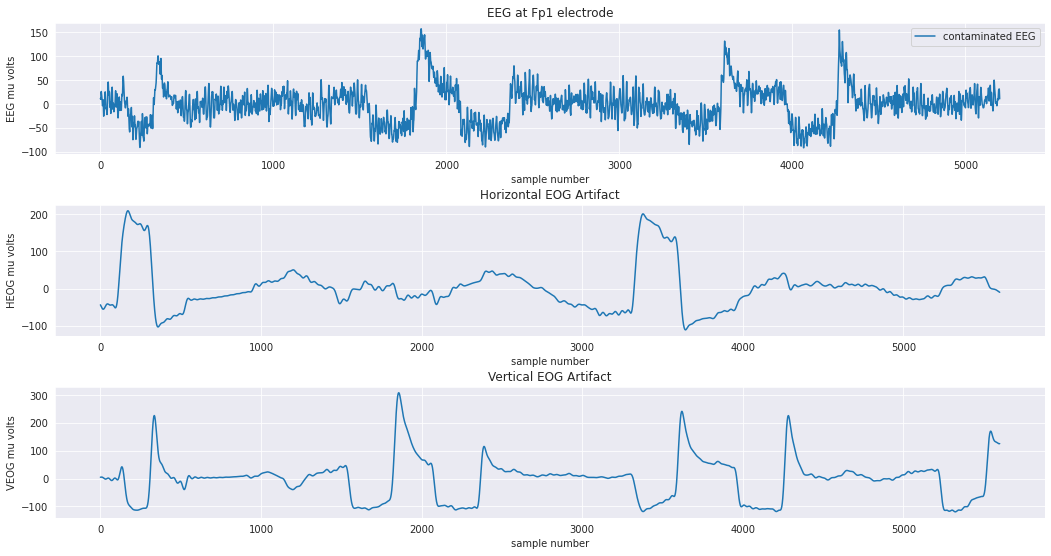

In [ ]:
index_selected_electrode = 0

# Plot pure EEG, contaminated EEG of selected electrode, HEOG, VEOG
fig, axs = createSubplot(3)

plt.sca(axs[0])
# plt.plot(selectedLength_pureEEG["sim1_resampled"][index_selected_electrode], label="pure EEG") 
plt.plot(selectedLength_contEEG["sim1_con"][index_selected_electrode], label="contaminated EEG") 
plt.xlabel("sample number")
plt.ylabel("EEG mu volts")
plt.title(f"EEG at {EEG_electrodes[index_selected_electrode]} electrode")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(initial_HEOG["heog_1"][0])
plt.xlabel("sample number")
plt.ylabel("HEOG mu volts")
plt.title("Horizontal EOG Artifact")

plt.sca(axs[2])
plt.plot(initial_VEOG["veog_1"][0])
plt.xlabel("sample number")
plt.ylabel("VEOG mu volts")
plt.title("Vertical EOG Artifact")

plt.show()

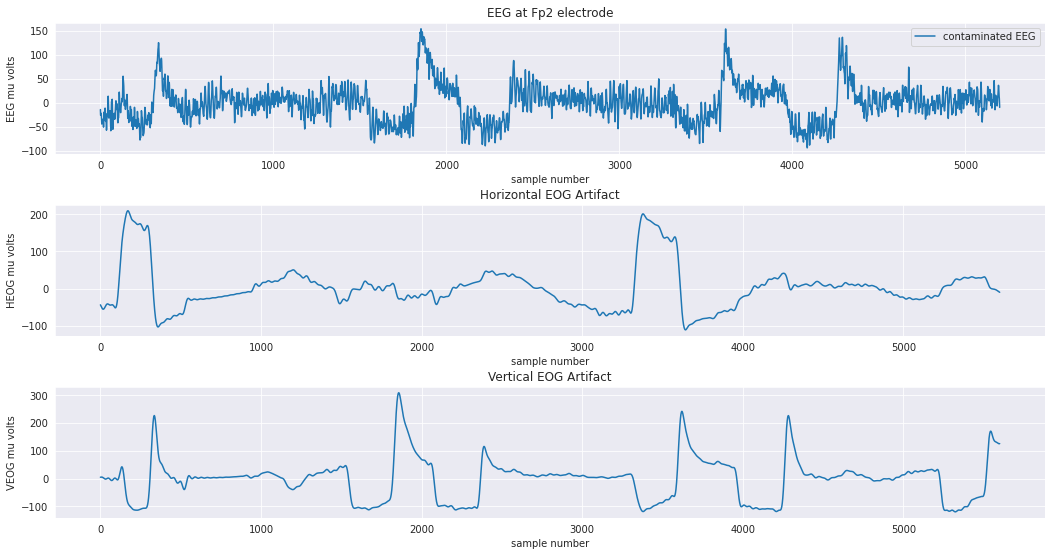

In [ ]:
index_selected_electrode = 1

# Plot pure EEG, contaminated EEG of selected electrode, HEOG, VEOG
fig, axs = createSubplot(3)

plt.sca(axs[0])
# plt.plot(selectedLength_pureEEG["sim1_resampled"][index_selected_electrode], label="pure EEG") 
plt.plot(selectedLength_contEEG["sim1_con"][index_selected_electrode], label="contaminated EEG") 
plt.xlabel("sample number")
plt.ylabel("EEG mu volts")
plt.title(f"EEG at {EEG_electrodes[index_selected_electrode]} electrode")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(initial_HEOG["heog_1"][0])
plt.xlabel("sample number")
plt.ylabel("HEOG mu volts")
plt.title("Horizontal EOG Artifact")

plt.sca(axs[2])
plt.plot(initial_VEOG["veog_1"][0])
plt.xlabel("sample number")
plt.ylabel("VEOG mu volts")
plt.title("Vertical EOG Artifact")

plt.show()

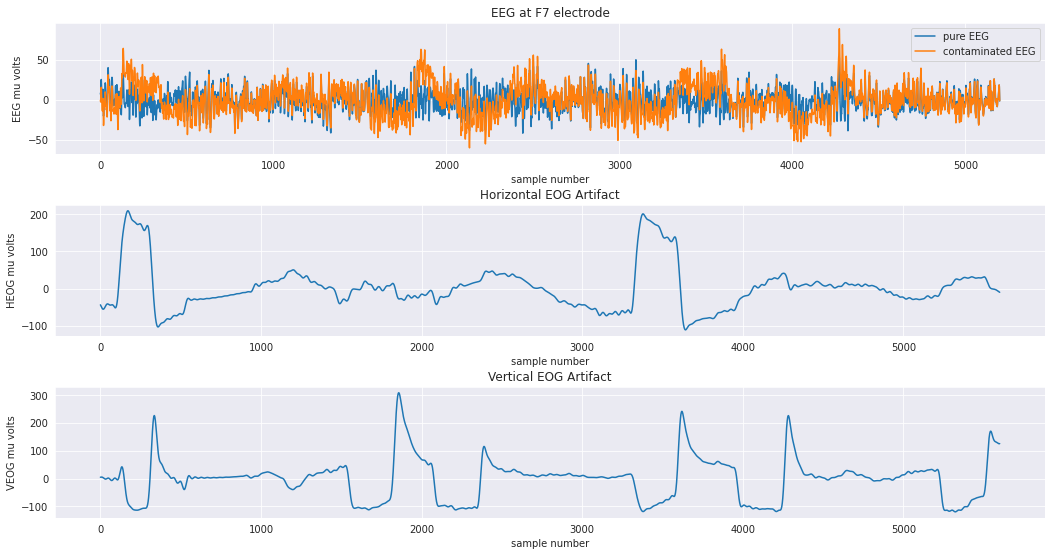

In [ ]:
index_selected_electrode = 10

# Plot pure EEG, contaminated EEG of selected electrode, HEOG, VEOG
fig, axs = createSubplot(3)

plt.sca(axs[0])
plt.plot(selectedLength_pureEEG["sim1_resampled"][index_selected_electrode], label="pure EEG") 
plt.plot(selectedLength_contEEG["sim1_con"][index_selected_electrode], label="contaminated EEG") 
plt.xlabel("sample number")
plt.ylabel("EEG mu volts")
plt.title(f"EEG at {EEG_electrodes[index_selected_electrode]} electrode")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(initial_HEOG["heog_1"][0])
plt.xlabel("sample number")
plt.ylabel("HEOG mu volts")
plt.title("Horizontal EOG Artifact")

plt.sca(axs[2])
plt.plot(initial_VEOG["veog_1"][0])
plt.xlabel("sample number")
plt.ylabel("VEOG mu volts")
plt.title("Vertical EOG Artifact")

plt.show()

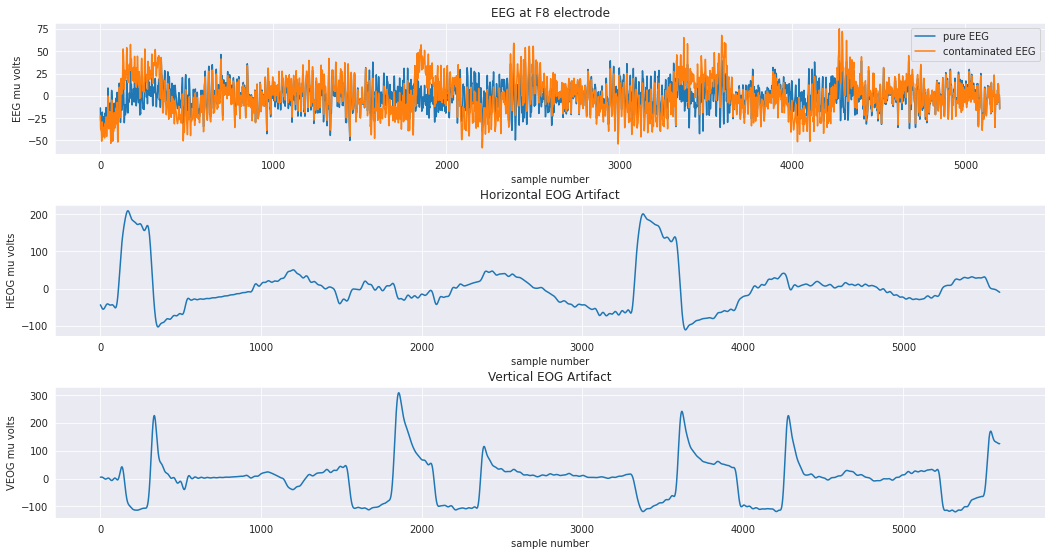

In [ ]:
index_selected_electrode = 11

# Plot pure EEG, contaminated EEG of selected electrode, HEOG, VEOG
fig, axs = createSubplot(3)

plt.sca(axs[0])
plt.plot(selectedLength_pureEEG["sim1_resampled"][index_selected_electrode], label="pure EEG") 
plt.plot(selectedLength_contEEG["sim1_con"][index_selected_electrode], label="contaminated EEG") 
plt.xlabel("sample number")
plt.ylabel("EEG mu volts")
plt.title(f"EEG at {EEG_electrodes[index_selected_electrode]} electrode")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(initial_HEOG["heog_1"][0])
plt.xlabel("sample number")
plt.ylabel("HEOG mu volts")
plt.title("Horizontal EOG Artifact")

plt.sca(axs[2])
plt.plot(initial_VEOG["veog_1"][0])
plt.xlabel("sample number")
plt.ylabel("VEOG mu volts")
plt.title("Vertical EOG Artifact")

plt.show()

In [ ]:
selected_Fp1_EEG = selectedLength_contEEG["sim1_con"][0]
selected_F7_EEG = selectedLength_contEEG["sim1_con"][10]
minus_Fp1F7_EEG = selected_Fp1_EEG - selected_F7_EEG

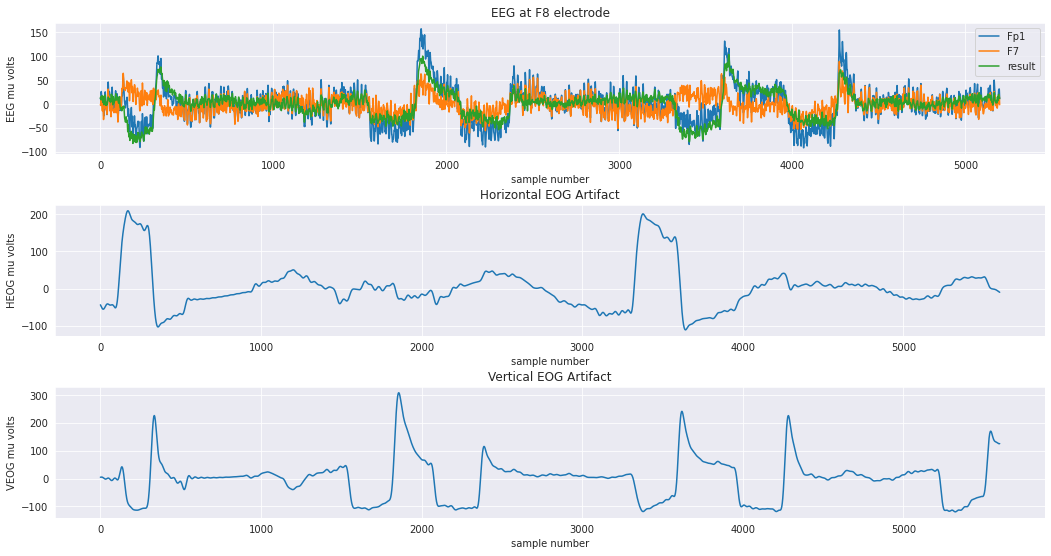

In [ ]:
# Plot pure EEG, contaminated EEG of selected electrode, HEOG, VEOG
fig, axs = createSubplot(3)

plt.sca(axs[0])
plt.plot(selected_Fp1_EEG, label="Fp1") 
plt.plot(selected_F7_EEG, label="F7") 
plt.plot(minus_Fp1F7_EEG, label="result")
plt.xlabel("sample number")
plt.ylabel("EEG mu volts")
plt.title(f"EEG at {EEG_electrodes[index_selected_electrode]} electrode")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(initial_HEOG["heog_1"][0])
plt.xlabel("sample number")
plt.ylabel("HEOG mu volts")
plt.title("Horizontal EOG Artifact")

plt.sca(axs[2])
plt.plot(initial_VEOG["veog_1"][0])
plt.xlabel("sample number")
plt.ylabel("VEOG mu volts")
plt.title("Vertical EOG Artifact")

plt.show()

In [ ]:
selected_Fp2_EEG = selectedLength_contEEG["sim1_con"][1]
selected_F8_EEG = selectedLength_contEEG["sim1_con"][11]
minus_Fp2F8_EEG = selected_Fp2_EEG - selected_F8_EEG

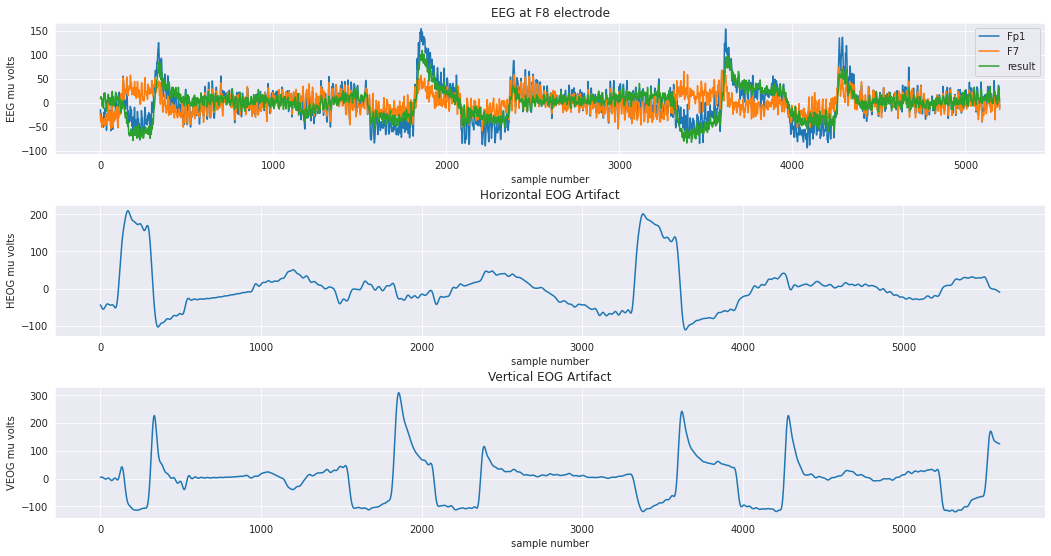

In [ ]:
# Plot pure EEG, contaminated EEG of selected electrode, HEOG, VEOG
fig, axs = createSubplot(3)

plt.sca(axs[0])
plt.plot(selected_Fp2_EEG, label="Fp1") 
plt.plot(selected_F8_EEG, label="F7") 
plt.plot(minus_Fp2F8_EEG, label="result")
plt.xlabel("sample number")
plt.ylabel("EEG mu volts")
plt.title(f"EEG at {EEG_electrodes[index_selected_electrode]} electrode")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(initial_HEOG["heog_1"][0])
plt.xlabel("sample number")
plt.ylabel("HEOG mu volts")
plt.title("Horizontal EOG Artifact")

plt.sca(axs[2])
plt.plot(initial_VEOG["veog_1"][0])
plt.xlabel("sample number")
plt.ylabel("VEOG mu volts")
plt.title("Vertical EOG Artifact")

plt.show()

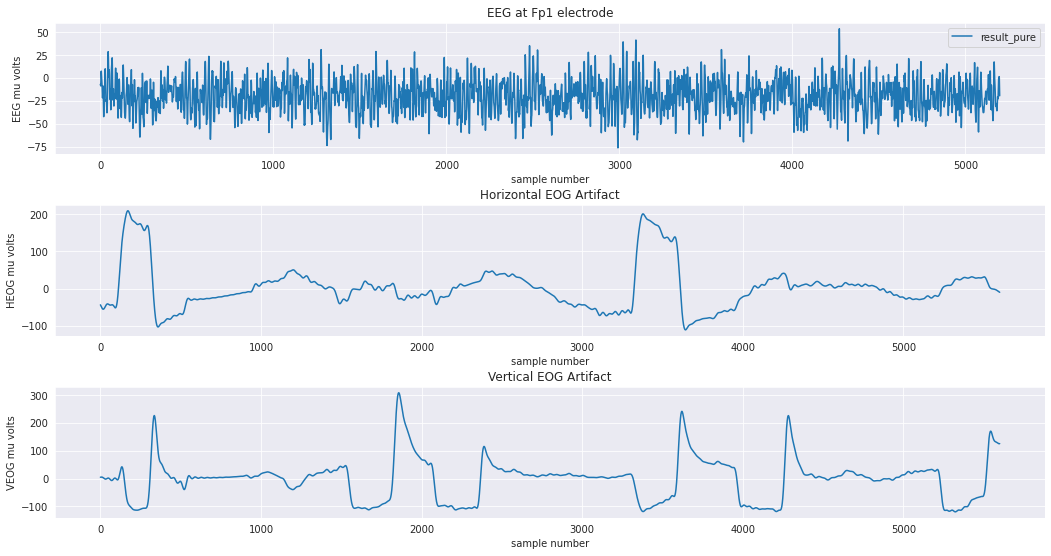

In [ ]:
result_pure = selectedLength_pureEEG["sim1_resampled"][0] - selectedLength_pureEEG["sim1_resampled"][0][10] - selectedLength_pureEEG["sim1_resampled"][0][1] + selectedLength_pureEEG["sim1_resampled"][0][11]
result_cont = minus_Fp1F7_EEG - minus_Fp2F8_EEG
# Plot pure EEG, contaminated EEG of selected electrode, HEOG, VEOG
fig, axs = createSubplot(3)

plt.sca(axs[0])
# plt.plot(minus_Fp1F7_EEG, label="Fp1F7") 
# plt.plot(minus_Fp2F8_EEG, label="Fp12F8") 
plt.plot(result_pure, label="result_pure")
# plt.plot(result_cont, label="result_cont", alpha=0.7)
plt.xlabel("sample number")
plt.ylabel("EEG mu volts")
plt.title(f"EEG at {EEG_electrodes[index_selected_electrode]} electrode")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(initial_HEOG["heog_1"][0])
plt.xlabel("sample number")
plt.ylabel("HEOG mu volts")
plt.title("Horizontal EOG Artifact")

plt.sca(axs[2])
plt.plot(initial_VEOG["veog_1"][0])
plt.xlabel("sample number")
plt.ylabel("VEOG mu volts")
plt.title("Vertical EOG Artifact")

plt.show()

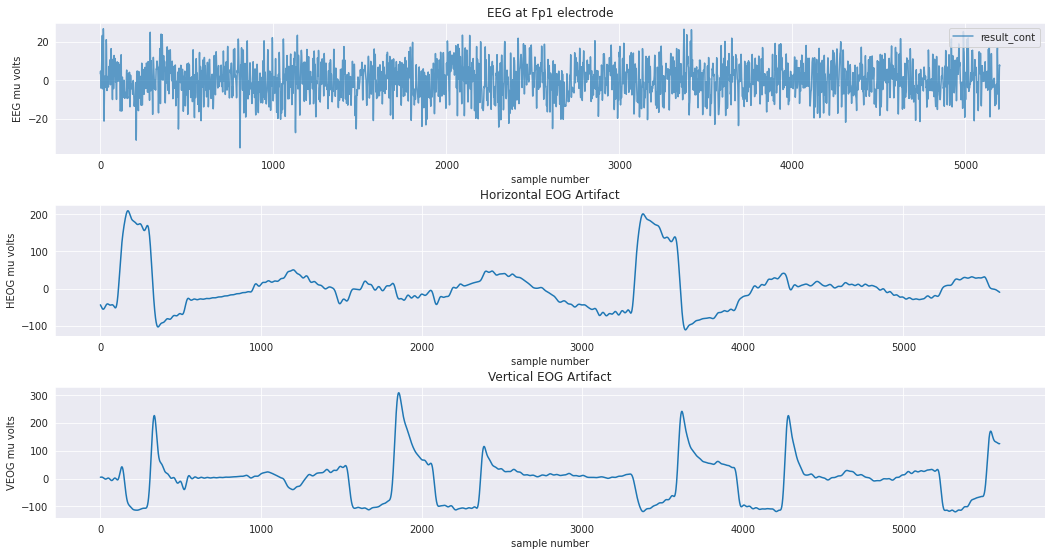

In [ ]:
result_pure = selectedLength_pureEEG["sim1_resampled"][0] - selectedLength_pureEEG["sim1_resampled"][0][10] - selectedLength_pureEEG["sim1_resampled"][0][1] + selectedLength_pureEEG["sim1_resampled"][0][11]
result_cont = minus_Fp1F7_EEG - minus_Fp2F8_EEG
# Plot pure EEG, contaminated EEG of selected electrode, HEOG, VEOG
fig, axs = createSubplot(3)

plt.sca(axs[0])
# plt.plot(minus_Fp1F7_EEG, label="Fp1F7") 
# plt.plot(minus_Fp2F8_EEG, label="Fp12F8") 
# plt.plot(result_pure, label="result_pure")
plt.plot(result_cont, label="result_cont", alpha=0.7)
plt.xlabel("sample number")
plt.ylabel("EEG mu volts")
plt.title(f"EEG at {EEG_electrodes[index_selected_electrode]} electrode")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(initial_HEOG["heog_1"][0])
plt.xlabel("sample number")
plt.ylabel("HEOG mu volts")
plt.title("Horizontal EOG Artifact")

plt.sca(axs[2])
plt.plot(initial_VEOG["veog_1"][0])
plt.xlabel("sample number")
plt.ylabel("VEOG mu volts")
plt.title("Vertical EOG Artifact")

plt.show()

### Decomposition by DWT

From the input signal's sampling frequency was **200 Hz** and OAs occur due to eye moment and eye-blinks and have freuqncy ranges of 0-7 Hz and 8-13 Hz

- level 01: 50-100 Hz
- level 02: 25-50 Hz
- level 03: 12.5-25 Hz
- level 04: 6.25-12.5 Hz
- level 05: 3.125-6.25 Hz
- level 06: 1.5625-3.125 Hz
- level 07: 0.78125-1.5625 Hz
- level 08: 0.390625-0.78125 Hz



In [ ]:
selectedLength_contEEG.keys()

dict_keys(['sim1_con', 'sim2_con', 'sim3_con', 'sim4_con', 'sim5_con', 'sim6_con', 'sim7_con', 'sim8_con', 'sim9_con', 'sim10_con', 'sim11_con', 'sim12_con', 'sim13_con', 'sim14_con', 'sim15_con', 'sim16_con', 'sim17_con', 'sim18_con', 'sim19_con', 'sim20_con', 'sim21_con', 'sim22_con', 'sim23_con', 'sim24_con', 'sim25_con', 'sim26_con', 'sim27_con', 'sim28_con', 'sim29_con', 'sim30_con', 'sim31_con', 'sim32_con', 'sim33_con', 'sim34_con', 'sim35_con', 'sim36_con', 'sim37_con', 'sim38_con', 'sim39_con', 'sim40_con', 'sim41_con', 'sim42_con', 'sim43_con', 'sim44_con', 'sim45_con', 'sim46_con', 'sim47_con', 'sim48_con', 'sim49_con', 'sim50_con', 'sim51_con', 'sim52_con', 'sim53_con', 'sim54_con'])

In [ ]:
selectedMotherWavelet = "bior3.9"
selecteddecompositionLevel = 8
test_waveletCoeffs = pywt.wavedec(selectedLength_contEEG['sim1_con'],
                                  wavelet=selectedMotherWavelet,
                                  level=selecteddecompositionLevel)

# Structure of the result from decompostiion
# coefficients level (list) -> [19, coefficients] (numpy)

test_waveletCoeffs[8].shape


# test_select_contEEG = selectedLength_contEEG['sim1_con']
# print(test_select_contEEG.shape)

# test_waveletCoeffs = pywt.wavedec(selectedLength_contEEG['sim1_con'],
#                                   wavelet=selectedMotherWavelet,
#                                   level=selecteddecompositionLevel)
# # Structure of the result from decompostiion
# # coefficients level (list) -> [19, coefficients] (numpy)


# print(len(test_waveletCoeffs))
# print(test_waveletCoeffs[0].shape)
# print(test_waveletCoeffs[0][0].shape)

# print(type(test_waveletCoeffs))
# print(type(test_waveletCoeffs[0]))
# print(type(test_waveletCoeffs[0][0]))

# denoised_EEG = pywt.waverec(test_waveletCoeffs,
#                             wavelet=selectedMotherWavelet)

# print(denoised_EEG.shape)

(19, 2609)

In [ ]:
test_waveletCoeffs[8].shape

(19, 2609)

In [ ]:
def decompositionDWT(dict_inputEEG, motherWavelet, decompositionLevel):
    """
    Dictionary's structure is 
    1) Subjects
    2) Electrodes
    3) Coefficients (With 8 decomposition level: cA8, cD8, cD7, ..., cD1)
    """
    EEG_electrodes = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 
                  'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
    
    dict_manySubject_coeffs = dict()
    for subject, manyCH_EEG in dict_inputEEG.items():
        dict_manyCH_coeffs = {}
        for idx_EEGch, oneCH_EEG in enumerate(manyCH_EEG): 
            waveletCoeffs = pywt.wavedec(oneCH_EEG,wavelet=selectedMotherWavelet,level=selecteddecompositionLevel)
            dict_manyCH_coeffs[EEG_electrodes[idx_EEGch]] = waveletCoeffs
        dict_manySubject_coeffs[subject] = dict_manyCH_coeffs
    return dict_manySubject_coeffs

# Select a mother wavelet(basis function) and a decomposition level
selectedMotherWavelet = "bior3.9"
selecteddecompositionLevel = 8

DWTcoeff_pureEEG = decompositionDWT(dict_inputEEG=selectedLength_pureEEG,
                                    motherWavelet=selectedMotherWavelet,
                                    decompositionLevel=selecteddecompositionLevel)
DWTcoeff_contEEG = decompositionDWT(dict_inputEEG=selectedLength_contEEG,
                                    motherWavelet=selectedMotherWavelet,
                                    decompositionLevel=selecteddecompositionLevel)

# DWTcoeff_pureEEG.keys()
# DWTcoeff_contEEG['sim54_con']['Pz'][0]

In [ ]:
# DWTcoeff_contEEG['sim1_con']['Fp1']

In [ ]:
def interpolate_waveletCoefficients(dict_inputEEG):
    dict_interpolatedWaveletCoeffs_subjects = dict()
    for subject, electrode in dict_inputEEG.items():
        dict_interpolatedWaveletCoeffs_manyCH = dict()
        for electrodeName, listwaveletCoeff in electrode.items():
            for idx_waveletCoeff, waveletCoeff in enumerate(listwaveletCoeff):
                if idx_waveletCoeff == 0:
                    interpolatedWaveletCoeffs_oneCH = waveletCoeff
                else:
                    interpolatedWaveletCoeffs_oneCH = np.hstack((interpolatedWaveletCoeffs_oneCH, waveletCoeff))
            dict_interpolatedWaveletCoeffs_manyCH[electrodeName] = interpolatedWaveletCoeffs_oneCH
        dict_interpolatedWaveletCoeffs_subjects[subject] = dict_interpolatedWaveletCoeffs_manyCH
    return dict_interpolatedWaveletCoeffs_subjects


interpolated_DWTcoeff_pureEEG = interpolate_waveletCoefficients(DWTcoeff_pureEEG)
interpolated_DWTcoeff_contEEG = interpolate_waveletCoefficients(DWTcoeff_contEEG)

In [ ]:
def getCoeffShape(dict_inputEEG):
    coeffNames = ['cA8', 'cD8', 'cD7', 'cD6', 'cD5', 'cD4', 'cD3', 'cD2', 'cD1']
    oneCH_coeffShape = dict()
    interpolated_coeffShape = 0
    sum_interpolated_coeffShape = dict()
    
    for subject, electrode in dict_inputEEG.items():
        for electrodeName, listwaveletCoeff in electrode.items():
            for idx_waveletCoeff, waveletCoeff in enumerate(listwaveletCoeff):
                oneCH_coeffShape[coeffNames[idx_waveletCoeff]] = waveletCoeff.shape[0]
                interpolated_coeffShape = interpolated_coeffShape + waveletCoeff.shape[0]
                sum_interpolated_coeffShape[coeffNames[idx_waveletCoeff]] = interpolated_coeffShape
            break
        break
#     coeffShape["Total"] = interpolated_coeffShape
    return oneCH_coeffShape, sum_interpolated_coeffShape

summary_pureEEG_coeffShape = getCoeffShape(DWTcoeff_pureEEG)
print(summary_pureEEG_coeffShape[0])
print('-'*100)
print(summary_pureEEG_coeffShape[1])
print('*'*100)

summary_contEEG_coeffShape = getCoeffShape(DWTcoeff_contEEG)
print(summary_contEEG_coeffShape[0])
print('-'*100)
print(summary_contEEG_coeffShape[1])
print('*'*100)

{'cA8': 39, 'cD8': 39, 'cD7': 59, 'cD6': 99, 'cD5': 180, 'cD4': 342, 'cD3': 666, 'cD2': 1314, 'cD1': 2609}
----------------------------------------------------------------------------------------------------
{'cA8': 39, 'cD8': 78, 'cD7': 137, 'cD6': 236, 'cD5': 416, 'cD4': 758, 'cD3': 1424, 'cD2': 2738, 'cD1': 5347}
****************************************************************************************************
{'cA8': 39, 'cD8': 39, 'cD7': 59, 'cD6': 99, 'cD5': 180, 'cD4': 342, 'cD3': 666, 'cD2': 1314, 'cD1': 2609}
----------------------------------------------------------------------------------------------------
{'cA8': 39, 'cD8': 78, 'cD7': 137, 'cD6': 236, 'cD5': 416, 'cD4': 758, 'cD3': 1424, 'cD2': 2738, 'cD1': 5347}
****************************************************************************************************


In [ ]:
def grab_children(father):
    nestedDict_to_lists = []
    for key, value in father.items():
#         print(f"value is {value}")
        if type(value) == dict:
#             print(f"It is dictionary")
#             print('-'*100)
#             print(value)
            nestedDict_to_lists.append(grab_children(value))
#         elif type(father).__module__ == np.__name__:
        else:
#             print(type(value))
#             print(f"It is link list")
            nestedDict_to_lists.append(value)
#             print(nestedDict_to_lists)
#             print('='*100)
    return nestedDict_to_lists

test_dict_to_lists = np.array(grab_children(interpolated_DWTcoeff_pureEEG))
print(test_dict_to_lists.shape)
print(type(test_dict_to_lists))
# print(t_dict_to_lists)
print('='*100)

(54, 19, 5347)
<class 'numpy.ndarray'>


In [ ]:
numpy_interpolated_DWTcoeff_pureEEG = np.array(grab_children(interpolated_DWTcoeff_pureEEG))
numpy_interpolated_DWTcoeff_contEEG = np.array(grab_children(interpolated_DWTcoeff_contEEG))

print(numpy_interpolated_DWTcoeff_pureEEG.shape)
print(type(numpy_interpolated_DWTcoeff_pureEEG))
# print(numpy_interpolated_DWTcoeff_pureEEG)
print('='*100)

print(numpy_interpolated_DWTcoeff_contEEG.shape)
print(type(numpy_interpolated_DWTcoeff_contEEG))
# print(numpy_interpolated_DWTcoeff_contEEG)
print('='*100)

# print(numpy_interpolated_DWTcoeff_pureEEG[53,-3,406:416])

(54, 19, 5347)
<class 'numpy.ndarray'>
(54, 19, 5347)
<class 'numpy.ndarray'>


In [ ]:
numpy_interpolated_DWTcoeff_pureEEG[5,2,15:25]

array([-17.105734 , -67.108    ,  84.81194  , -97.26291  ,  89.16943  ,
       -49.716988 ,  25.657555 ,   7.748556 , -40.56978  ,  -1.4120367],
      dtype=float32)

In [ ]:
numpy_interpolated_DWTcoeff_contEEG[5,2,15:25]

array([-161.2860701 ,   41.57961385,   68.28931775,    9.06851284,
         64.52984327, -270.00909112,  109.52719106,  133.27561205,
         59.36391041, -258.82005723])

In [ ]:
purepure_EEGcoeffs = np.concatenate((numpy_interpolated_DWTcoeff_pureEEG,
                                     numpy_interpolated_DWTcoeff_pureEEG), axis=2)
contpure_EEGcoeffs = np.concatenate((numpy_interpolated_DWTcoeff_contEEG,
                                     numpy_interpolated_DWTcoeff_pureEEG), axis=2)
print(purepure_EEGcoeffs.shape)
print(contpure_EEGcoeffs.shape)

# Data for models
coeffs_for_models = np.vstack((purepure_EEGcoeffs,contpure_EEGcoeffs))
print(coeffs_for_models.shape)

(54, 19, 10694)
(54, 19, 10694)
(108, 19, 10694)


In [ ]:
n_total_features = summary_contEEG_coeffShape[1]['cD1']
n_total_targets = coeffs_for_models.shape[-1] - n_total_features
print(f"Number of EEG's features is {n_total_features} and Number of EEG's target is {n_total_targets}")

coeffs_for_models_features = coeffs_for_models[:,:,:n_total_features]
coeffs_for_models_targets = coeffs_for_models[:,:,n_total_features:]

Number of EEG's features is 5347 and Number of EEG's target is 5347


In [ ]:
coeffs_for_models_features[5,2,15:25]

array([-17.10573387, -67.10800171,  84.81194305, -97.26290894,
        89.16943359, -49.71698761,  25.65755463,   7.74855614,
       -40.56977844,  -1.41203666])

In [ ]:
coeffs_for_models_targets[5,2,15:25]

array([-17.10573387, -67.10800171,  84.81194305, -97.26290894,
        89.16943359, -49.71698761,  25.65755463,   7.74855614,
       -40.56977844,  -1.41203666])

In [ ]:
coeffs_for_models_features[59,2,15:25]

array([-161.2860701 ,   41.57961385,   68.28931775,    9.06851284,
         64.52984327, -270.00909112,  109.52719106,  133.27561205,
         59.36391041, -258.82005723])

In [ ]:
coeffs_for_models_targets[59,2,15:25]

array([-17.10573387, -67.10800171,  84.81194305, -97.26290894,
        89.16943359, -49.71698761,  25.65755463,   7.74855614,
       -40.56977844,  -1.41203666])

In [ ]:
# Shuffle and Separate data
x_train, x_test, y_train, y_test = train_test_split(coeffs_for_models_features, coeffs_for_models_targets, 
                                                    test_size=0.2, random_state=42)

In [ ]:
x_train.shape

(86, 19, 5347)

In [ ]:
x_test.shape

(22, 19, 5347)

In [ ]:
highestCoeffs_for_lowFreq = summary_contEEG_coeffShape[1]['cD5']
lowestCoeffs_for_highFreq = x_train.shape[-1] - highestCoeffs_for_lowFreq

lowFreq_x_train = x_train[:,:,:highestCoeffs_for_lowFreq]
highFreq_x_train = x_train[:,:,highestCoeffs_for_lowFreq:]
lowFreq_y_train = y_train[:,:,:highestCoeffs_for_lowFreq]
highFreq_y_train = y_train[:,:,highestCoeffs_for_lowFreq:]

lowFreq_x_test= x_test[:,:,:highestCoeffs_for_lowFreq]
highFreq_x_test = x_test[:,:,highestCoeffs_for_lowFreq:]
lowFreq_y_test= y_test[:,:,:highestCoeffs_for_lowFreq]
highFreq_y_test = y_test[:,:,highestCoeffs_for_lowFreq:]

# print(lowFreq_x_train.shape)
# print(highFreq_x_train.shape)

In [ ]:
lowFreq_x_train.shape

(86, 19, 416)

In [ ]:
# Reshape 3d input to 2d input
reshape_lowFreq_x_train = lowFreq_x_train.reshape(-1,highestCoeffs_for_lowFreq)
# reshape_highFreq_x_train = highFreq_x_train.reshape(-1,lowestCoeffs_for_highFreq)
reshape_lowFreq_y_train = lowFreq_y_train.reshape(-1,highestCoeffs_for_lowFreq)
# reshape_highFreq_y_train = highFreq_y_train.reshape(-1,lowestCoeffs_for_highFreq)

reshape_lowFreq_x_test= lowFreq_x_test.reshape(-1,highestCoeffs_for_lowFreq)
# reshape_highFreq_x_test = highFreq_x_test.reshape(-1,lowestCoeffs_for_highFreq)
reshape_lowFreq_y_test= lowFreq_y_test.reshape(-1,highestCoeffs_for_lowFreq)
# reshape_highFreq_y_test = highFreq_y_test.reshape(-1,lowestCoeffs_for_highFreq)

In [ ]:
reshape_lowFreq_x_train.shape

(1634, 416)

## ANN model

In [ ]:
# get the model
def get_model(n_inputs, n_outputs):
    n_1st_hiddenLayer = 1250
    n_2nd_hiddenLayer = 1250
    model = Sequential()
    model.add(Dense(n_1st_hiddenLayer, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_2nd_hiddenLayer, input_dim=n_1st_hiddenLayer, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    return model

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        history_model = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=0, 
                                  callbacks=[csv_logger])
        # evaluate model on test set
        history_evaluation = model.evaluate(X_test, y_test, verbose=0)
        # store result
        print('>%.3f' % history_evaluation)
        results.append(history_evaluation)
        
    return results, model, history_model, history_evaluation

# logs = Callback()
csv_logger = CSVLogger('training.log', separator=',', append=False)
# evaluate model
evaluateModel = evaluate_model(reshape_lowFreq_x_train, 
                               reshape_lowFreq_y_train)
results = evaluateModel[0]
model = evaluateModel[1]
history_model = evaluateModel[2]
history_evaluation = evaluateModel[3]
# summarize performance
# print('mse: %.3f (%.3f)' % (np.mean(results), np.std(results)))

>20489.021
>821.909
>963.240
>553.396
>987.507
>411.799
>1169.159
>640.960
>871.621
>16143.946
>469.299
>21900.865
>1274.601
>1269.478
>690.386
>481.756
>1957.746
>572.696
>12182.025
>546.170
>1703.181
>779.389
>1635.355
>16479.363
>18726.918
>594.554
>1303.357
>436.764
>446.474
>2379.013


In [ ]:
history_model.history.keys()

dict_keys(['loss', 'val_loss'])

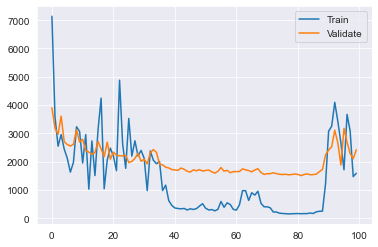

In [ ]:
plt.plot(history_model.history['loss'], label="Train")
plt.plot(history_model.history['val_loss'], label="Validate")
plt.legend(loc="upper right")
plt.show()

## Save the model

In [ ]:
# # Create log (csv file) to save history data
# # csv_logger = CSVLogger('training.log', separator=',', append=False)
# # Load history data from log (csv file)
# log_data = pd.read_csv('WNN_03_allCH_training_01.log', sep=',', engine='python')

# log_data['loss'].plot()
# log_data['val_loss'].plot()

In [ ]:
# # Save the model
# model.save('04_WNN_03_allCH.h5')

# # Load a model
# from keras.models import load_model
# loaded_model = load_model('04_WNN_03_multiCH.h5')

In [ ]:
lowFreq_x_train[0].shape

(19, 416)

In [ ]:
lowFreq_x_train.shape

(86, 19, 416)

In [ ]:
purepure_EEGcoeffs[0,0,10:20]

array([  2.5544837 ,  18.020313  , -63.83017   ,  45.982357  ,
       -60.83667   ,   0.86438423, -20.377302  ,  -9.670498  ,
        -7.140142  , -38.01962   ], dtype=float32)

In [ ]:
purepure_EEGcoeffs[0,0,5357:5367]

array([  2.5544837 ,  18.020313  , -63.83017   ,  45.982357  ,
       -60.83667   ,   0.86438423, -20.377302  ,  -9.670498  ,
        -7.140142  , -38.01962   ], dtype=float32)

In [ ]:
contpure_EEGcoeffs[0,0,10:20]

array([  319.83789309,  -198.60017744,   205.67416809,  -293.88481654,
         711.99035926, -1690.53736109,  2176.80513483, -1824.3299397 ,
         736.73760643,   -52.08284961])

In [ ]:
contpure_EEGcoeffs[0,0,5357:5367]

array([  2.55448365,  18.02031326, -63.83016968,  45.98235703,
       -60.83666992,   0.86438423, -20.37730217,  -9.67049789,
        -7.14014196, -38.01961899])

## Denosing conmatinated coefficients

In [ ]:
# Select pair of pure and contaminate one subject's coeffs to denoise (denoise only lowFreq coeffs)

selected_cont_EEGcoeffs = contpure_EEGcoeffs[:,:,:n_total_features]
selected_pure_EEGcoeffs = contpure_EEGcoeffs[:,:,n_total_targets:]
print(selected_cont_EEGcoeffs.shape)
print('-'*100)

# Separate low-high coefficients
selected_lowFreq_cont_EEGcoeffs = selected_cont_EEGcoeffs[:,:,:highestCoeffs_for_lowFreq]
selected_highFreq_cont_EEGcoeffs =selected_cont_EEGcoeffs[:,:,highestCoeffs_for_lowFreq:]

print(selected_lowFreq_cont_EEGcoeffs.shape)
print(selected_highFreq_cont_EEGcoeffs.shape)
print('-'*100)

# denoise each electrode in one subject
lowFreq_denoised_coeffs_subjects = []
for e_subject in selected_lowFreq_cont_EEGcoeffs:
    lowFreq_denoised_coeffs_multiCH = []
    for e_electrode in e_subject:
#             print(e_electrode.shape)
        lowFreq_cont_coeffs_oneCH = e_electrode.reshape(1,highestCoeffs_for_lowFreq)
#             print(lowFreq_cont_coeffs_oneCH[0,:5])
#             print('-'*100)
        lowFreq_denoised_coeffs_oneCH = model.predict(lowFreq_cont_coeffs_oneCH)
#         print(lowFreq_denoised_coeffs_oneCH.shape)
        lowFreq_denoised_coeffs_multiCH.append(lowFreq_denoised_coeffs_oneCH)
#             print(lowFreq_denoised_coeffs_oneCH[0,:5])
#             print('='*100)
    lowFreq_denoised_coeffs_multiCH = np.array(lowFreq_denoised_coeffs_multiCH).reshape(19,416)
#     print(np.array(lowFreq_denoised_coeffs_multiCH).shape)
    lowFreq_denoised_coeffs_subjects.append(lowFreq_denoised_coeffs_multiCH)
    print(np.array(lowFreq_denoised_coeffs_subjects).shape)

print('-'*100)
lowFreq_denoised_coeffs_subjects = np.array(lowFreq_denoised_coeffs_subjects)

# Reshape to (54subjects, 19 electrodes, coeffs)
lowFreq_denoised_coeffs = lowFreq_denoised_coeffs_subjects
highFreq_denoised_coeffs= selected_highFreq_cont_EEGcoeffs

print(lowFreq_denoised_coeffs.shape)
print(highFreq_denoised_coeffs.shape)
print('-'*100)

# Combine low-high coefficients
denoised_coeffs = np.concatenate((lowFreq_denoised_coeffs, highFreq_denoised_coeffs), axis=2)
print(denoised_coeffs.shape)
print('-'*100)

(54, 19, 5347)
----------------------------------------------------------------------------------------------------
(54, 19, 416)
(54, 19, 4931)
----------------------------------------------------------------------------------------------------
(1, 19, 416)
(2, 19, 416)
(3, 19, 416)
(4, 19, 416)
(5, 19, 416)
(6, 19, 416)
(7, 19, 416)
(8, 19, 416)
(9, 19, 416)
(10, 19, 416)
(11, 19, 416)
(12, 19, 416)
(13, 19, 416)
(14, 19, 416)
(15, 19, 416)
(16, 19, 416)
(17, 19, 416)
(18, 19, 416)
(19, 19, 416)
(20, 19, 416)
(21, 19, 416)
(22, 19, 416)
(23, 19, 416)
(24, 19, 416)
(25, 19, 416)
(26, 19, 416)
(27, 19, 416)
(28, 19, 416)
(29, 19, 416)
(30, 19, 416)
(31, 19, 416)
(32, 19, 416)
(33, 19, 416)
(34, 19, 416)
(35, 19, 416)
(36, 19, 416)
(37, 19, 416)
(38, 19, 416)
(39, 19, 416)
(40, 19, 416)
(41, 19, 416)
(42, 19, 416)
(43, 19, 416)
(44, 19, 416)
(45, 19, 416)
(46, 19, 416)
(47, 19, 416)
(48, 19, 416)
(49, 19, 416)
(50, 19, 416)
(51, 19, 416)
(52, 19, 416)
(53, 19, 416)
(54, 19, 416)
-------

In [ ]:
denoised_coeffs.shape

(54, 19, 5347)

## Reshape coefficients for wavelet reconstruction

In [ ]:
# The structure of the result of wavelet decomposition is
# List of decomposition levels
# Electrodes
# Coefficients
print(test_waveletCoeffs[0].shape)
print(test_waveletCoeffs[-1].shape)

(19, 39)
(19, 2609)


In [ ]:
reshape_coeffs_subjects = []
for idx_e_subject, e_subject in enumerate(selected_EEGcoeffs):
#     print(e_subject.shape)
    
    list_np_manyCH_coeffs = []
    for idx_coeffLevel, samplesSize in enumerate(summary_size[0].values()):
        
        if idx_coeffLevel == 0:
            idx_start = 0
            idx_end = samplesSize
        else:
            idx_start = idx_end
            idx_end = idx_start + samplesSize
            
        list_np_oneCH_coeffs = []
        for e_electrode_coeff in e_subject:
#             print(e_electrode_coeff.shape)
            reshape_np_oneCH_coeffs = e_electrode_coeff[idx_start:idx_end]
            
#             print(reshape_np_oneCH_coeffs.shape)
            
            list_np_oneCH_coeffs.append(reshape_np_oneCH_coeffs)
            
#             print(np.array(list_np_oneCH_coeffs).shape)
#             print('-'*100)
            
        list_np_manyCH_coeffs.append(np.array(list_np_oneCH_coeffs))
#         list_np_manyCH_coeffs.append(list_np_oneCH_coeffs)
#         print(np.array(list_np_manyCH_coeffs).shape)
    reshape_coeffs_subjects.append(list_np_manyCH_coeffs)

# # For checking values' positions
# print(len(reshape_coeffs_subjects))
# print(len(reshape_coeffs_subjects[53]))
# print(reshape_coeffs_subjects[53][0].shape)
# print(reshape_coeffs_subjects[53][3][0,:])
# print('-'*100)
# print(denoised_coeffs[53,0,59+39+39+0:99+59+39+39].shape)
# print(denoised_coeffs[53,0,59+39+39+0:99+59+39+39])

In [ ]:
def reshapeCoeffsForWaveletReconstruct(selected_EEGcoeffs,summary_size):
    reshape_coeffs_subjects = []
    for idx_e_subject, e_subject in enumerate(selected_EEGcoeffs):
        list_np_manyCH_coeffs = []
        for idx_coeffLevel, samplesSize in enumerate(summary_size[0].values()):
            if idx_coeffLevel == 0:
                idx_start = 0
                idx_end = samplesSize
            else:
                idx_start = idx_end
                idx_end = idx_start + samplesSize
            list_np_oneCH_coeffs = []
            for e_electrode_coeff in e_subject:
                reshape_np_oneCH_coeffs = e_electrode_coeff[idx_start:idx_end]
                list_np_oneCH_coeffs.append(reshape_np_oneCH_coeffs)
            list_np_manyCH_coeffs.append(np.array(list_np_oneCH_coeffs))
        reshape_coeffs_subjects.append(list_np_manyCH_coeffs)
    return reshape_coeffs_subjects

# # For checking values' positions
# print(len(reshape_coeffs_subjects))
# print(len(reshape_coeffs_subjects[53]))
# print(reshape_coeffs_subjects[53][0].shape)
# print(reshape_coeffs_subjects[53][3][0,:])
# print('-'*100)
# print(denoised_coeffs[53,0,59+39+39+0:99+59+39+39].shape)
# print(denoised_coeffs[53,0,59+39+39+0:99+59+39+39])

In [ ]:
reshape_pure_EEGcoeffs = reshapeCoeffsForWaveletReconstruct(selected_EEGcoeffs=selected_pure_EEGcoeffs, 
                                                                         summary_size=summary_pureEEG_coeffShape)

reshape_cont_EEGcoeffs = reshapeCoeffsForWaveletReconstruct(selected_EEGcoeffs=selected_cont_EEGcoeffs, 
                                                                         summary_size=summary_contEEG_coeffShape)

reshape_denoised_coeffs = reshapeCoeffsForWaveletReconstruct(selected_EEGcoeffs=denoised_coeffs, 
                                                                         summary_size=summary_contEEG_coeffShape)

print(denoised_coeffs.shape)
print(len(reshape_denoised_coeffs))
print(len(reshape_denoised_coeffs[50]))
print(reshape_denoised_coeffs[50][2].shape)

(54, 19, 5347)
54
9
(19, 59)


## Select coeffcients of a subject and reconstruct pure/cont/denoised EEG signals

In [ ]:
reconstructed_pure_EEG = []
reconstructed_cont_EEG = []
denoised_EEG = []

for idx_e_subject in range(number_subjects):
    
    # Select coefficients of a subject
    selected_reshape_pure_EEGcoeffs = reshape_pure_EEGcoeffs[idx_e_subject]
    selected_reshape_cont_EEGcoeffs = reshape_cont_EEGcoeffs[idx_e_subject]
    selected_reshape_denoised_coeffs = reshape_denoised_coeffs[idx_e_subject]
    
    # Reconstruct EEG signals
    reconstructed_pure_EEG_oneSubject = pywt.waverec(selected_reshape_pure_EEGcoeffs,
                                                     wavelet=selectedMotherWavelet)
    reconstructed_cont_EEG_oneSubject = pywt.waverec(selected_reshape_cont_EEGcoeffs,
                                                     wavelet=selectedMotherWavelet)
    denoised_EEG_oneSubject = pywt.waverec(selected_reshape_denoised_coeffs,
                                           wavelet=selectedMotherWavelet)
    # Add signals to lists
    reconstructed_pure_EEG.append(reconstructed_pure_EEG_oneSubject)
    reconstructed_cont_EEG.append(reconstructed_cont_EEG_oneSubject)
    denoised_EEG.append(denoised_EEG_oneSubject)
    
# Change list to Numpy
reconstructed_pure_EEG = np.array(reconstructed_pure_EEG)
reconstructed_cont_EEG = np.array(reconstructed_cont_EEG)
denoised_EEG = np.array(denoised_EEG)
    
#     print(idx_e_subject)

print(reconstructed_pure_EEG.shape)

(54, 19, 5200)


In [ ]:
# # Select coefficients of a subject
# selected_idx_subject = 0

# selected_reshape_pure_EEGcoeffs = reshape_pure_EEGcoeffs[selected_idx_subject]
# selected_reshape_cont_EEGcoeffs = reshape_cont_EEGcoeffs[selected_idx_subject]
# selected_reshape_denoised_coeffs = reshape_denoised_coeffs[selected_idx_subject]

# reconstructed_pure_EEG = pywt.waverec(selected_reshape_pure_EEGcoeffs,wavelet=selectedMotherWavelet)
# print(reconstructed_pure_EEG.shape)

# reconstructed_cont_EEG = pywt.waverec(selected_reshape_cont_EEGcoeffs,wavelet=selectedMotherWavelet)
# print(reconstructed_cont_EEG.shape)

# denoised_EEG = pywt.waverec(selected_reshape_denoised_coeffs,wavelet=selectedMotherWavelet)
# print(denoised_EEG.shape)

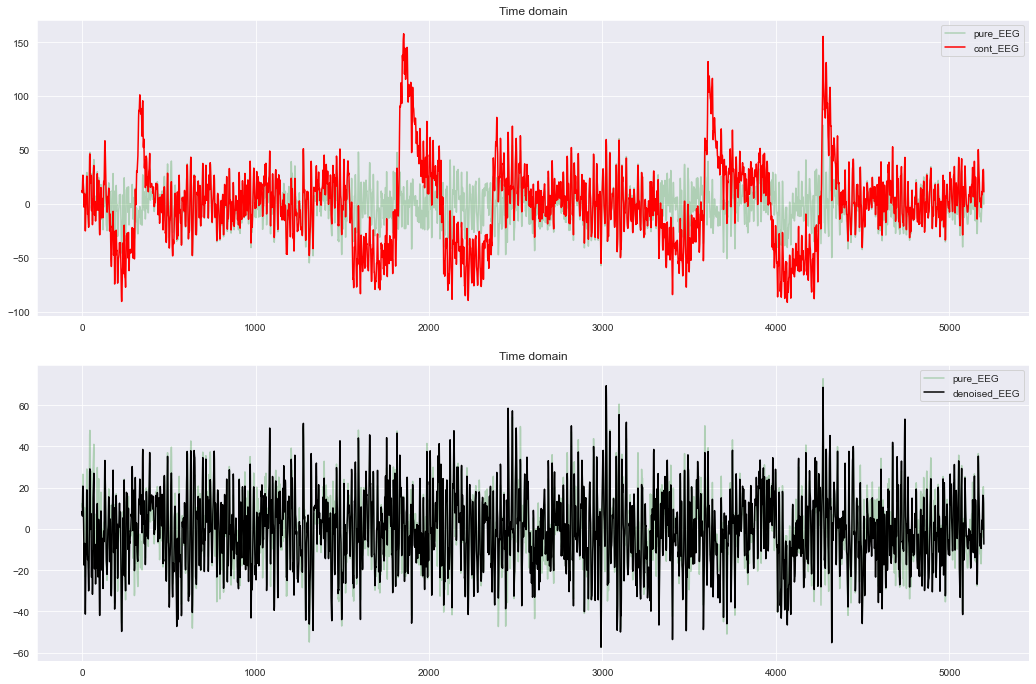

In [ ]:
def createSubplot(n):
    fig,axs = plt.subplots(n,figsize=(15,10))
    fig.tight_layout(pad=3.0)
    return fig,axs

# Prepare subplots
fig, axs = createSubplot(2)
# Select a subject's electrode
selected_idx_subject = 0
selected_idx_electrode = 0

plt.sca(axs[0])
plt.plot(reconstructed_pure_EEG[selected_idx_subject,
                                selected_idx_electrode,:], label="pure_EEG", color="g", alpha=0.25)
plt.plot(reconstructed_cont_EEG[selected_idx_subject,
                                selected_idx_electrode,:], label="cont_EEG", color="r")
plt.title("Time domain")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(reconstructed_pure_EEG[selected_idx_subject,
                                selected_idx_electrode,:], label="pure_EEG", color="g", alpha=0.25)
plt.plot(denoised_EEG[selected_idx_subject,
                                selected_idx_electrode,:], label="denoised_EEG", color="k")
# plt.plot(denoised_EEG[index_selected_electrode,:], label="denoised_EEG", color="k")
plt.title("Time domain")
plt.legend(loc="upper right")

plt.show()

## Performance metrics

In [ ]:
def calculate_SAR(cont_EEG,denoised_EEG):
    """
    Calculate Signal to Artifact Ratio (SAR)
    """
    SAR = 10*np.log(np.std(cont_EEG) / np.std(cont_EEG-denoised_EEG))
    return SAR


def calculate_RMSE(pure_EEG, denoised_EEG):
    """
    Calculate RMSE in dB scale (log based E)
    """
    diff_EEG = pure_EEG-denoised_EEG
#     print(f"Shape of pure_EEG: {pure_EEG.shape}")
#     print(f"Shape of cont_EEG: {denoised_EEG.shape}")
#     print(f"Shape of diff_EEG: {diff_EEG.shape}")
#     print('-'*50)
    RMSE = np.mean(np.power(diff_EEG,2))
    return RMSE

In [ ]:
# selectedLength_pureEEG.keys()
# selectedLength_contEEG.keys()

list_denoised_EEG_keys = list(selectedLength_contEEG.keys())

In [ ]:
subjects_manyCHs_SAR = {}

for idx_e_subject in range(number_subjects):
    manyCH_SAR = []
    manyCH_contEEG = reconstructed_cont_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_SAR = calculate_SAR(cont_EEG=manyCH_contEEG[idx_channel], 
                          denoised_EEG=manyCH_denoisedEEG[idx_channel])
        manyCH_SAR.append(oneCH_SAR)
    subjects_manyCHs_SAR[list_denoised_EEG_keys[idx_e_subject]] = manyCH_SAR
    
# Create DataFrame for SAR
df_SAR = pd.DataFrame(data=subjects_manyCHs_SAR, 
                      index= EEG_electrodes,
                      columns=subjects_manyCHs_SAR.keys())

# print(f"Avg. SAR of each Electrodes: \n{df_SAR.mean(axis=1)}")
df_SAR

,sim1_con,sim2_con,sim3_con,sim4_con,sim5_con,sim6_con,sim7_con,sim8_con,sim9_con,sim10_con,...,sim45_con,sim46_con,sim47_con,sim48_con,sim49_con,sim50_con,sim51_con,sim52_con,sim53_con,sim54_con
Fp1,1.160895,1.917528,2.551130,2.072649,4.502654,1.097229,0.743011,1.122478,1.298520,0.537584,...,0.615244,0.236818,-0.114227,0.129758,0.043915,0.200780,0.079980,0.265082,-0.201439,0.521098
Fp2,1.112663,1.792171,2.010893,1.887950,2.662346,1.008872,0.653092,0.941967,1.403600,0.415281,...,1.271530,0.176820,5.012922,0.017494,0.464818,0.041089,0.043709,0.272103,1.311989,0.862709
F3,5.110851,7.388201,6.557049,5.716225,8.542831,4.713903,5.136909,3.930376,2.085218,1.947114,...,1.999576,0.843630,0.656614,1.200227,0.878034,0.856529,0.780266,1.480139,0.370859,2.490815
F4,6.547285,7.506410,6.063240,5.862837,5.206594,4.105370,4.298648,3.596463,2.173359,2.433189,...,2.866141,0.560331,1.127907,-0.512286,1.418268,0.248226,0.564125,1.407238,2.655444,4.912195
C3,9.532325,13.832289,10.164144,11.583966,10.717591,7.947121,7.905669,6.820976,4.422455,3.793417,...,4.948438,3.823921,2.250190,3.570570,2.957350,2.837627,3.607108,4.092732,0.304304,5.886442
C4,10.830390,13.655375,10.292351,9.550407,1.409671,5.353589,7.194093,6.776200,4.659756,5.657951,...,4.920146,4.063583,3.618270,-1.709814,3.879494,0.164146,3.885447,3.416106,5.176222,8.694418
P3,15.579511,18.504007,11.348811,14.236847,11.668476,9.747385,8.669715,8.015310,5.234618,5.707185,...,9.495961,10.811148,3.550434,7.453511,5.655564,6.547193,6.685305,7.506283,1.912194,7.531796
P4,17.535640,19.946235,12.497158,13.539782,5.745367,9.205091,5.914733,10.109900,5.854755,7.549663,...,11.121324,11.264119,6.460308,1.281304,7.097741,0.009457,8.888512,5.729959,7.983769,9.304956
O1,14.568699,16.211991,6.490506,10.885835,9.544753,10.606873,9.582617,7.726315,6.442292,7.950924,...,5.968382,9.022530,5.710656,8.884336,8.039522,10.790933,8.039834,9.759476,4.542989,4.773946
O2,17.080607,17.478324,13.010252,10.088764,8.115120,10.454042,7.001631,12.344633,9.753184,9.315934,...,6.844652,7.464063,5.967497,-0.830610,7.940018,-0.027866,11.051912,6.212153,8.422774,9.991081


In [ ]:
subjects_manyCHs_RMSE = {}

for idx_e_subject in range(number_subjects):
    manyCH_RMSE = []
    manyCH_pureEEG = reconstructed_pure_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_RMSE = calculate_RMSE(pure_EEG=manyCH_pureEEG[idx_channel], 
                          denoised_EEG=manyCH_denoisedEEG[idx_channel])
        manyCH_RMSE.append(oneCH_RMSE)
    subjects_manyCHs_RMSE[list_denoised_EEG_keys[idx_e_subject]] = manyCH_RMSE
    
# Create DataFrame for RMSE
df_RMSE = pd.DataFrame(data=subjects_manyCHs_RMSE, 
                      index= EEG_electrodes,
                      columns=subjects_manyCHs_RMSE.keys())

# print(f"Avg. RMSE of each Electrodes: \n{df_RMSE.mean(axis=1)}")
df_RMSE

,sim1_con,sim2_con,sim3_con,sim4_con,sim5_con,sim6_con,sim7_con,sim8_con,sim9_con,sim10_con,...,sim45_con,sim46_con,sim47_con,sim48_con,sim49_con,sim50_con,sim51_con,sim52_con,sim53_con,sim54_con
Fp1,51.839444,62.706468,107.318536,30.762881,37.972098,21.250430,241.303756,17.488634,174.898450,22.969096,...,32.022860,21.156382,30.837403,33.469716,180.322891,29.849932,43.468419,36.167489,369.085257,37.727705
Fp2,29.085456,96.571672,105.273665,17.716631,73.555817,28.831366,186.610817,27.071534,187.952133,18.419948,...,37.821671,31.037439,18.185497,127.430052,99.021917,72.994905,25.496015,38.464980,136.623682,63.481259
F3,28.296347,9.349724,25.908437,13.498510,11.693777,4.758982,38.690130,7.205192,44.321338,8.501419,...,8.765107,9.174077,8.387302,10.643231,45.918118,14.057697,28.028141,12.659333,140.053224,20.013047
F4,68.023203,16.494878,25.654700,13.601566,33.943401,6.166540,27.116111,12.171881,33.328661,6.906801,...,19.127228,14.743155,8.366001,121.351609,40.690563,72.563384,12.417577,11.969183,72.391913,27.219754
C3,26.647928,9.886229,20.745823,12.445526,7.826102,8.307401,19.229426,10.730264,13.103612,7.865401,...,7.789309,6.854125,7.972800,8.608754,22.968337,10.040463,16.424317,8.912045,100.284445,13.764237
C4,11.232833,11.408776,12.000493,17.582785,30.131321,10.673942,16.568500,7.680292,12.197070,6.945327,...,13.902070,5.651472,8.175902,128.483610,22.829173,62.056605,5.911636,7.938479,36.956176,25.350259
P3,17.794804,12.000072,22.374748,14.630686,7.537959,8.545634,16.014888,15.562384,12.867038,5.800515,...,14.791049,10.783423,12.035658,8.509944,16.300144,3.641976,20.084578,8.207142,57.107827,10.145271
P4,7.021255,6.176618,15.460564,12.879946,30.893002,9.509713,42.383589,10.819661,13.292648,8.600394,...,11.248723,10.728678,10.490916,97.824611,14.431028,78.041110,8.155466,12.720353,21.980246,23.544392
O1,14.341965,12.841118,68.847736,30.160684,11.645691,7.580490,21.834317,31.686331,12.121278,6.437319,...,7.955814,6.238658,10.996697,12.484163,14.655101,3.265286,16.920379,7.157425,19.689544,23.613233
O2,11.594196,13.714868,16.290317,29.997278,24.980527,14.804178,57.137702,11.885336,10.706233,13.086696,...,16.372999,8.277489,22.738805,100.659571,13.621870,90.510263,7.381915,12.564318,28.599124,18.485001
